In [1]:
import pickle
import numpy as np
import pandas as pd
import os
import glob
import time

import sys
sfp = '/home/ngrav/project' 
sys.path.append(sfp)
from wearables.scripts import utils as wearutils
from wearables.scripts import data_v42 as weardata
from wearables.scripts import models_v42 as wearmodels
from wearables.scripts import train_v42 as weartrain
from wearables.scripts import eval_v42 as weareval

import torch

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

In [2]:
glob.glob('/home/ngrav/project/wearables/results/*csv')

['/home/ngrav/project/wearables/results/eval_test_v42.csv',
 '/home/ngrav/project/wearables/results/train_v42.csv']

In [19]:
res_eval = pd.read_csv('/home/ngrav/project/wearables/results/eval_test_v42.csv', index_col=0)
np.mean([float(i) for i in res_eval.iloc[4::2, 4].to_list()])
# [print(type(i)) for i in res_eval.iloc[4]]

7.971225182215373

In [20]:
np.std([float(i) for i in res_eval.iloc[4::2, 4].to_list()])


1.2651180555776949

# trouble shoot why the heck the thing is not saving models


In [2]:
net = wearmodels.CNN(2, 10080, 1, [(1, 32), (1, 64), (1, 128), (3, 256)])

In [7]:
# train
trainer = weartrain.train(
    net, exp='CNNL1L1shorthighLR',
    criterion=weartrain.MSEL1(), 
    trial=0,
    n_epochs=100,
    lr=0.01,
    patience=10,
    min_nb_epochs=10,
    out_file='/home/ngrav/project/wearables/results/train_v42.csv',
    model_path='/home/ngrav/scratch/wearables_model_zoo',
    device=torch.device('cuda:{}'.format(1)))
# trainer.fit()

In [27]:
!export CUDA_LAUNCH_BLOCKING=1

In [28]:
def tensor_mem_size(a):
    size = (a.element_size() * a.nelement()) / (1e6) # MB
    return '{:.0f} MB'.format(size)
a = torch.rand(32, 10080)
print(tensor_mem_size(a))

# send to device
a.to(torch.device('cuda:2'))

1 MB


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [33]:
x = next(iter(trainer.data.train_dl))['x']
x.shape

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

torch.Size([32, 2, 10080])

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [40]:
class GRU(nn.Module):
    '''Basic comparison for a 2 layer, final hidden unit clf using LSTM
    '''
    def __init__(self, d_in, d_hidden, nb_layers, T, d_out):
        super().__init__()
        self.d_in = d_in
        self.d_hidden = d_hidden
        self.nb_layers = nb_layers
        self.T = T
        self.d_out = d_out
        
        # blocks
        self.gru = nn.GRU(d_in, d_hidden, 
                            num_layers=nb_layers, 
                            bidirectional=True, 
                            batch_first=True, 
                            dropout=0.5)
        self.pred = nn.Sequential(
            nn.Linear(d_in*d_hidden, d_in*d_hidden // 2),
            nn.LeakyReLU(),
            nn.Linear(d_in*d_hidden // 2, d_out)
        )
    
    def forward(self, X):
        # X shape (N, d_in, T) where d_in=data dim (activity counts and light intensity)
        _, h_n = self.gru(X.transpose(2, 1))
        # https://discuss.pytorch.org/t/how-to-concatenate-the-hidden-states-of-a-bi-lstm-with-multiple-layers/39798/5
        ##  h_n = h_n.view(num_layers, num_directions, batch, hidden_size)
        h_n = h_n.reshape(self.nb_layers, 2, -1, self.d_hidden)[-1]
        h_n = h_n.reshape(-1, 2*self.d_hidden)
        return self.pred(h_n)

In [41]:
net = GRU(2, 64, 3, 10080, 1)

In [42]:
net(x)

tensor([[ 0.0443],
        [ 0.0574],
        [ 0.0241],
        [ 0.0419],
        [ 0.0319],
        [ 0.0459],
        [ 0.0033],
        [ 0.0201],
        [ 0.0273],
        [-0.0123],
        [-0.0019],
        [ 0.0192],
        [ 0.0354],
        [ 0.0428],
        [ 0.0343],
        [ 0.0159],
        [-0.0105],
        [ 0.0299],
        [-0.0562],
        [-0.0055],
        [-0.0210],
        [-0.0019],
        [-0.0245],
        [-0.0199],
        [-0.0492],
        [ 0.0081],
        [-0.0472],
        [-0.0154],
        [-0.0124],
        [-0.0383],
        [-0.0637],
        [-0.0312]], grad_fn=<AddmmBackward>)

# process existing word files

In [44]:
glob.glob('/home/ngrav/project/wearables/experiments/jobs/*log')

['/home/ngrav/project/wearables/experiments/jobs/CNNL1L2_n3.log',
 '/home/ngrav/project/wearables/experiments/jobs/CNNL1L2_n1.log',
 '/home/ngrav/project/wearables/experiments/jobs/CNNL1L2_n2.log',
 '/home/ngrav/project/wearables/experiments/jobs/ITL1L2_n1.log',
 '/home/ngrav/project/wearables/experiments/jobs/LSTML1L2_n1.log']

In [61]:
import re

In [82]:
epoch_times = []
loss = []
loss_val = []
with open('/home/ngrav/project/wearables/experiments/jobs/ITL1L2_n1.log', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i>=2:
            editline = line.strip().split('\t')
            timing = editline[3]
            timing = re.findall(r' (.[0-9]*)-s', timing)
            timing = float(timing[0])
            epoch_times.append(timing)
            loss.append(float(editline[1].split('=')[1]))
            loss_val.append(float(editline[2].split('=')[1]))

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


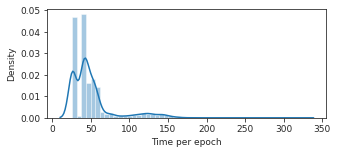

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
sns.distplot(epoch_times, ax=ax)
ax.set_xlabel('Time per epoch')
fig.savefig('/home/ngrav/project/wearables/results/epoch_times_IT_lowLR_L1.png', bbox_inches='tight', dpi=300)

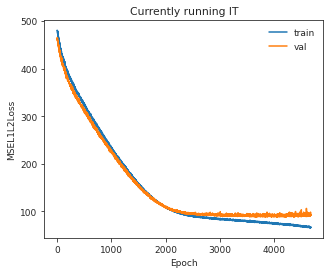

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(np.arange(len(loss)), loss, label='train')
ax.plot(np.arange(len(loss_val)), loss_val, label='val')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('MSEL1L2Loss')
ax.set_title('Currently running IT')
fig.savefig('/home/ngrav/project/wearables/results/train_val_loss_IT_lowLR_L1.png', bbox_inches='tight', dpi=300)

# check bst CNN training curves, select a better patience 

In [88]:
res_eval = pd.read_csv('/home/ngrav/project/wearables/results/eval_test_v42.csv', index_col=0)
res_eval

,exp_trial,y,yhat,loss,mae,rho,P_rho
0.0,CNN_GA_0,"tensor([23., 34., 11., 25., 15., 15., 32., 34....","tensor([23.3786, 33.3094, 13.5194, 37.4183, 23...",152.42417907714844,9.988155364990234,0.21078738668303154,6.429204097637882e-09
NaN,exp_trial,y,yhat,loss,mae,rho,P_rho
0.0,CNN_GA_1,"tensor([18., 36., 32., 11., 28., 32., 14., 19....","tensor([19.9934, 18.6679, 20.0464, 23.8355, 22...",105.37854766845703,8.16934871673584,0.26936495206250644,7.514909637607e-14
NaN,exp_trial,y,yhat,loss,mae,rho,P_rho
0.0,CNNMSEl1_GA_1,"tensor([34., 19., 11., 34., 24., 24., 7., 24....","tensor([32.5890, 16.9544, 10.3172, 23.5483, 14...",101.1440200805664,5.696577548980713,0.6775308931586468,2.372060594329595e-99
NaN,exp_trial,y,yhat,loss,mae,rho,P_rho
0.0,CNNL2_GA_2,"tensor([14., 24., 9., 32., 25., 12., 9., 13....","tensor([20.6975, 20.7298, 24.6287, 21.6757, 20...",119.56114959716797,7.824972152709961,0.3838162549841941,6.237310645180146e-27
NaN,exp_trial,y,yhat,loss,mae,rho,P_rho
0.0,CNNL1L2_GA_3,"tensor([ 8., 29., 34., 23., 11., 8., 20., 23....","tensor([14.0577, 19.6408, 18.1760, 26.1839, 20...",105.45992279052734,7.618980884552002,0.3768698799892931,3.7498922679454873e-26
NaN,exp_trial,y,yhat,loss,mae,rho,P_rho


In [90]:
# CNNL1L2_GA_3
res_train = pd.read_csv('/home/ngrav/project/wearables/results/train_v42.csv', index_col=0)
res_train.head()

,exp,trial,target,hyperparams,tasktype,bst_epoch,loss_train,loss_val
0,CNNL1L2_GA,1,GA,"{'criterion': MSEL1(\n (MSE): MSELoss()\n), '...",regression,2009,"[545.6215970126066, 534.156561834162, 516.1712...","[585.3072280883789, 569.4286193847656, 468.797..."
0,CNNL1L2_GA,2,GA,"{'criterion': MSEL1(\n (MSE): MSELoss()\n), '...",regression,2011,"[546.7280685989945, 535.2482655843099, 517.993...","[524.9254302978516, 511.6100667317708, 481.192..."
0,CNNL1L1shorthighLR_GA,0,GA,"{'criterion': MSEL1(\n (MSE): MSELoss()\n), '...",regression,12,"[289641.8208002161, 1171.21518057364, 1023.265...","[1221.3979085286458, 1065.2091776529949, 960.4..."


In [117]:
import ast
loss = ast.literal_eval(res_train.loc[res_train['trial']==1, 'loss_train'][0])
loss_val = ast.literal_eval(res_train.loc[res_train['trial']==1, 'loss_val'][0])


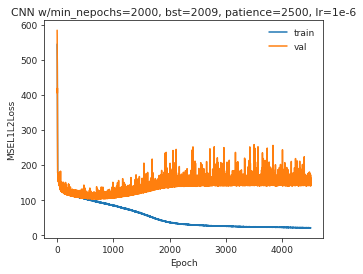

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(np.arange(len(loss)), loss, label='train')
ax.plot(np.arange(len(loss_val)), loss_val, label='val')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('MSEL1L2Loss')
ax.set_title('CNN w/min_nepochs=2000, bst=2009, patience=2500, lr=1e-6')
fig.savefig('/home/ngrav/project/wearables/results/train_val_loss_shitCNN_lowLR_L1.png', bbox_inches='tight', dpi=300)

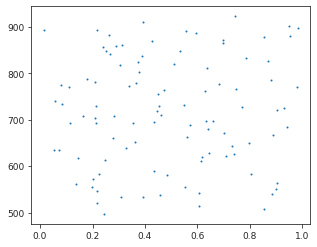

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.scatter(np.random.uniform(size=(100, )), np.argsort(loss_val)[:100], s=1)

In [136]:
print(np.argsort(loss_val)[:10])

[709 692 730 698 672 685 635 704 741 756]


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

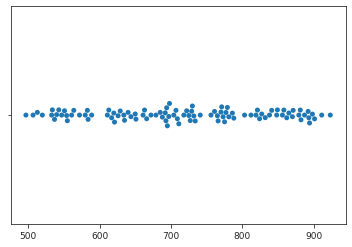

In [135]:
sns.swarmplot(np.argsort(loss_val)[:100])

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

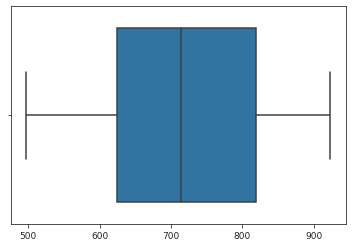

In [137]:
sns.boxplot(np.argsort(loss_val)[:100])

In [138]:
print(np.quantile(np.argsort(loss_val)[:100], q=[0.25, 0.75]))

[624.75 819.5 ]
